# Climate Data Fetch, Cleanup, and Save

This notebook downloads climate data from NOAA's FTP server for all stations listed in the stations file, and for the specified years. Cleanup and processing of the data is then performed to get each dataset into a single Pandas DataFrame, which is then written out to a file.

## Parameters

**stations_file**: the name of the CSV listing all the Meteoroligcal stations to look for. The first column is
the index of station IDs from NOAA's Integrated Surface Database (ISD). See https://www.ncdc.noaa.gov/isd/data-access

**fetch_host**: the domain name of the FTP server where the files are.

**fetch_dir**: the pattern of the directory structure containing the files.

In [1]:
stations_file = "Salish Sea met stations.csv"
fetch_host = "ftp.ncei.noaa.gov"
fetch_dir = "/pub/data/noaa/isd-lite/{year}/"

ftplib is included with Python 3. Pandas is required.

In [2]:
import pandas as pd
from ftplib import FTP

Read the stations CSV into a Pandas dataframe, indexed by the ISD number (column 0)

In [3]:
stations = pd.read_csv(stations_file, index_col=0)
stations.head()

,Name
ISD number,
727935-24234,Boeing Field
727935-99999,Boeing Field King Co
727976-24217,Bellingham Airport
720749-24255,Whidbey Airport
727923-94225,Hoquiam Airport


Connect to the FTP server.

Note that the server has an inactivity timeout, so you may need to re-run this cell to reconnect if you get
a timeout message later on.

In [4]:
ftp = FTP(fetch_host)
ftp.login()

'230-****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ** ** WARNING ** WARNING ** WARNING ******\n ** You are accessing a U.S. Government information system, which includes:                         **\n ** 1) This computer, 2)This computer network, 3) All computers connected to this network, and      **\n ** 4) All devices and storage media attached to this network or to a computer on this network.     **\n ** You understand and consent to the following:                                                    **\n ** you may access this information system for authorized use only; you have no reasonable          **\n ** expectation of privacy regarding any communication of data transiting or stored on this         **\n ** information system; at any time and for any lawful Government purpose, the Government may       **\n ** monitor, intercept, and search and seize any communication or data transiting or stored on      **\n ** this information system; and any communications or data 

The main code. Each file is a single station (named by station ID) for a single year. So iterate over the years,
and download all the available station files. The files which are available are determined by retrieving an FTP file listing, running the function file_callback on each one to check if it is in the stations Dataframe. If it is, add it to the list `avail_files`, which then gets iterated on to download the files one by one.

In [5]:
def do_download(ftp, stations, years, save_dir):
    avail_files = []
    def file_callback(line):
        filename = " ".join(line.split()).split(" ")[-1]
        stationid = filename[0:12]
        if stationid in stations.index:
            avail_files.append(filename)

    for year in years:
        avail_files = []
        ftp.cwd(fetch_dir.format(year=year))
        ftp.retrlines('LIST', callback = file_callback)
        for f in avail_files:
            with open(save_dir + f, 'wb') as fp:
                ftp.retrbinary("RETR {0}".format(f), fp.write)

Download all the climate data for all stations in the DF since 1980.

This cell can take a while to run.

In [6]:
do_download(ftp, stations, range(1980, 2021), "data/all-since-1980/")

When the download is finished, all the files will be in the save_dir. Files are gzipped.
Processing of the files is done next.

# Process Climate Data

Assembles all climate data files downloaded from NOAA's ISD-Lite dataset into a single Pandas DataFrame and
saves to a CSV output file.

Pandas' optional dependency `tables` is required. re, gzip and os are included with Python 3.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os
import re

For every file in the `data_dir` whose name matches `file_pattern`, load the data (via gzip) into Pandas as a fixed-width file. Perform the raw processing necessary to convert the raw integers into the proper scale and assemble the datetime objects. All DataFrames get concatenated together into one big DataFrame at the end.

In [8]:
# A compiled regex that matches all ISD-Lite file names. The first group in the file should match the station ID.
file_pattern = re.compile('([0-9-]{12})-[0-9]{4}\.gz')

def do_process(data_dir):
    dfs = []
    for f in os.listdir(data_dir):
        m = file_pattern.match(f)
        if m:
            with gzip.open(data_dir + f) as fp:
                # Widths must be specified!
                df = pd.read_fwf(fp, names=(
                    'year','month','day','hour','temp','dewpt','slp_hpa','wind_dir','wind_speed','skycond',
                    'precip_1hr','precip_6hr'), na_values=-9999,
                    widths=(4,3,3,3,6,6,6,6,6,6,6,6))
                # Adjust values per ISD format documentation
                for col in ('wind_speed','temp','dewpt','slp_hpa','precip_1hr','precip_6hr'):
                    df[col] /= 10
                # Parse the date info
                date_cols = ['year','month','day','hour']
                df['date'] = pd.to_datetime(df[date_cols])
                df['station_id'] = m.group(1)
                dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    # Perform some cleanup to remove junk
    
    # Set wind_dir to NaN if it was coded as 0 (calm winds)
    df.loc[df['wind_dir'] == 0, 'wind_dir'] = np.nan

    cols_in_order = ['station_id','date','temp','dewpt','slp_hpa','wind_dir','wind_speed','skycond','precip_1hr','precip_6hr']
    df = df[cols_in_order]
    
    return df

## All Station Data Since 1980

Process the initial 1980 to present data set

In [9]:
all_since_1980 = do_process("data/all-since-1980/")
all_since_1980

,station_id,date,temp,dewpt,slp_hpa,wind_dir,wind_speed,skycond,precip_1hr,precip_6hr
0,727935-24234,1990-01-01 00:00:00,7.8,6.1,NaN,190.0,5.1,7.0,NaN,NaN
1,727935-24234,1990-01-01 01:00:00,8.3,6.7,NaN,180.0,6.7,8.0,NaN,NaN
2,727935-24234,1990-01-01 02:00:00,7.8,6.1,NaN,190.0,6.7,8.0,NaN,NaN
3,727935-24234,1990-01-01 03:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN
4,727935-24234,1990-01-01 04:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3822344,727970-94240,2018-12-31 19:00:00,1.7,0.6,1032.7,70.0,1.5,0.0,0.0,NaN
3822345,727970-94240,2018-12-31 20:00:00,2.8,0.6,1032.3,80.0,2.1,0.0,0.0,NaN
3822346,727970-94240,2018-12-31 21:00:00,4.4,1.1,1031.6,NaN,0.0,2.0,0.0,NaN
3822347,727970-94240,2018-12-31 22:00:00,6.1,1.7,1031.8,NaN,0.0,NaN,0.0,NaN


Load the met stations CSV.

In [10]:
stations_file = 'Salish Sea met stations.csv'
stations = pd.read_csv(stations_file)
stations.head()

,ISD number,Name
0,727935-24234,Boeing Field
1,727935-99999,Boeing Field King Co
2,727976-24217,Bellingham Airport
3,720749-24255,Whidbey Airport
4,727923-94225,Hoquiam Airport


How many stations have at least some data for each year?

[Text(0, 0.5, 'Unique stations with >1 wind observation'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Number of wind observing stations by year')]

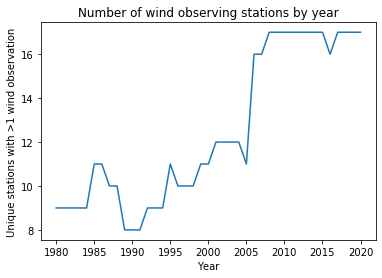

In [11]:
years = all_since_1980['date'].dt.year.sort_values().unique()
station_count = np.zeros_like(years)
for i, year in enumerate(years):
    # Get all the wind observations made in this year, then drop any rows which do not contain at least one
    # observation of wind (station_id is guaranteed to be non-NaN, so the threshold needs to be two)
    data_this_year = all_since_1980.loc[all_since_1980['date'].dt.year == year, ['station_id','wind_speed','wind_dir']].dropna(thresh=2)
    station_count[i] = len(data_this_year.groupby('station_id').count())
fig, ax = plt.subplots()
ax.plot(years, station_count)
ax.set(title="Number of wind observing stations by year", xlabel="Year", ylabel="Unique stations with >1 wind observation")

## Extract the Long-Run Station IDs

Okay, so there is not a record that is both spatially detailed and goes back many decades. Instead, let's figure out which stations go back the longest (there are at most 8 of those), and exactly which year all 16 recent stations came online.

Let's start by looking at all the unique station IDs for 1990, and merging with the stations list to see which those are.

In [12]:
stationids_1990 = all_since_1980.loc[all_since_1980['date'].dt.year == 1990, 'station_id'].unique()
stations.loc[stations['ISD number'].isin(stationids_1990)]

,ISD number,Name
0,727935-24234,Boeing Field
2,727976-24217,Bellingham Airport
5,727970-94240,Quillayute Airport
6,727930-24233,Seatac Airport
7,727920-24227,Olympia Airport
13,742065-99999,Point No Point CG Station
14,994350-99999,West Point
19,714730-99999,Saturna Island


Do all of those stations have data up to the last year we fetched?

[Text(0, 0.5, 'Observations per month'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Wind Speed observations per month for all active stations as of 1990')]

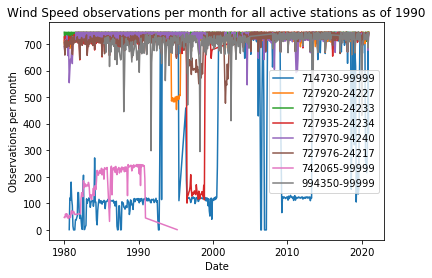

In [13]:
years = all_since_1980['date'].dt.year.sort_values().unique()
longrun_data = all_since_1980.loc[all_since_1980['station_id'].isin(stationids_1990), ['station_id','date','wind_speed','wind_dir']].dropna(thresh=2)
longrun_data['yearmonth'] = longrun_data['date'].dt.year + (longrun_data['date'].dt.month - 1) / 12
counts = longrun_data.groupby(['station_id','yearmonth']).count()
fig, ax = plt.subplots()
for name,group in counts.groupby(level=0):
    ax.plot(group.index.get_level_values(1).to_numpy(), group['wind_speed'].to_numpy(), label=name)
ax.legend()
ax.set(title="Wind Speed observations per month for all active stations as of 1990", ylabel="Observations per month", xlabel="Date")

Okay, so Saturna Island (714730-99999) and Point No Point (742065-99999) stations do not have much data. We need to exclude those, leaving us with only six stations. The others look like they only have brief blips of unavailability.

In [14]:
longrun_stationids = stationids_1990[(stationids_1990 != '714730-99999') & (stationids_1990 != '742065-99999')]
longrun_stationids

array(['727935-24234', '727920-24227', '727930-24233', '994350-99999',
       '727976-24217', '727970-94240'], dtype=object)

## Fetch Long Run Dataset

Create a subset of the overall stations CSV with just these six stations listed. This gets used to fetch climate data from ISD-Lite going back as far as we can

In [15]:
longrun_stations = stations.loc[stations['ISD number'].isin(longrun_stationids)].set_index('ISD number')
longrun_stations.to_csv('met_stations_longrun.csv')
do_download(ftp, longrun_stations, range(1960, 2021), "data/long-run-1960/")

Process the Long Run set

In [16]:
longrun = do_process("data/long-run-1960/")
longrun

,station_id,date,temp,dewpt,slp_hpa,wind_dir,wind_speed,skycond,precip_1hr,precip_6hr
0,727935-24234,1990-01-01 00:00:00,7.8,6.1,NaN,190.0,5.1,7.0,NaN,NaN
1,727935-24234,1990-01-01 01:00:00,8.3,6.7,NaN,180.0,6.7,8.0,NaN,NaN
2,727935-24234,1990-01-01 02:00:00,7.8,6.1,NaN,190.0,6.7,8.0,NaN,NaN
3,727935-24234,1990-01-01 03:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN
4,727935-24234,1990-01-01 04:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2473842,727970-94240,2018-12-31 19:00:00,1.7,0.6,1032.7,70.0,1.5,0.0,0.0,NaN
2473843,727970-94240,2018-12-31 20:00:00,2.8,0.6,1032.3,80.0,2.1,0.0,0.0,NaN
2473844,727970-94240,2018-12-31 21:00:00,4.4,1.1,1031.6,NaN,0.0,2.0,0.0,NaN
2473845,727970-94240,2018-12-31 22:00:00,6.1,1.7,1031.8,NaN,0.0,NaN,0.0,NaN


## Verification of Long-Run Station Completeness, Identification of Start Year

[Text(0, 0.5, 'Observations per month'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Wind Speed observations per month for long-running stations')]

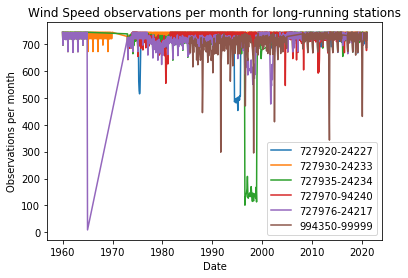

In [17]:
years = longrun['date'].dt.year.sort_values().unique()
longrun['yearmonth'] = longrun['date'].dt.year + (longrun['date'].dt.month - 1) / 12
counts = longrun.groupby(['station_id','yearmonth']).count()
fig, ax = plt.subplots()
for name,group in counts.groupby(level=0):
    ax.plot(group.index.get_level_values(1).to_numpy(), group['wind_speed'].to_numpy(), label=name)
ax.legend()
ax.set(title="Wind Speed observations per month for long-running stations", ylabel="Observations per month", xlabel="Date")

The historical record for these stations looks like it starts to get pretty sparse before 1975 or so, so that's as far back as this analysis can actually go.

Now, apply that filter to the dataset and save it to a file. HDF is used because it is a convenient compressed format. A CSV of this data would be quite large.

In [18]:
longrun = longrun.loc[longrun['date'].dt.year >= 1975]
# Drop that extra column created earlier
del longrun['yearmonth']
longrun.to_hdf('data/climate_data_longrun1975.h5', 'longrun',
               index=False, format='t', complib='zlib', complevel=9)

## Extract the Recent Station IDs

This follows a similar process to above. Get a list of all stations with observations in 2010, of which there are 16, and see whether their observation records are complete. Remove any stations from consideration which are missing large amounts of data, and settle on a start year for this part of the analysis.

In [19]:
stationids_2010 = all_since_1980.loc[all_since_1980['date'].dt.year == 2010, 'station_id'].unique()
stations.loc[stations['ISD number'].isin(stationids_2010)]

,ISD number,Name
0,727935-24234,Boeing Field
2,727976-24217,Bellingham Airport
3,720749-24255,Whidbey Airport
4,727923-94225,Hoquiam Airport
5,727970-94240,Quillayute Airport
6,727930-24233,Seatac Airport
7,727920-24227,Olympia Airport
8,727925-94227,Shelton Airport
10,727938-94274,Tacoma Narrows Airport
11,727928-94263,Bremerton Airport


Do all of those stations have data up to the last year we fetched?

[Text(0, 0.5, 'Observations per month'),
 (2005, 2022.9625),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Wind Speed observations per month for all active stations as of 1990')]

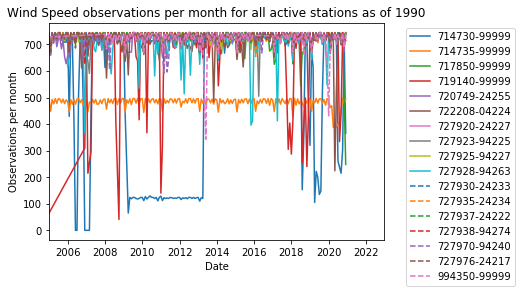

In [20]:
years = all_since_1980['date'].dt.year.sort_values().unique()
recentdense_data = all_since_1980.loc[all_since_1980['station_id'].isin(stationids_2010),
                                      ['station_id','date','wind_speed','wind_dir']].dropna(thresh=2)
recentdense_data['yearmonth'] = recentdense_data['date'].dt.year + (recentdense_data['date'].dt.month - 1) / 12
counts = recentdense_data.groupby(['station_id','yearmonth']).count()
fig, ax = plt.subplots()
# The default matplotlib color cycler only has ten colors, so after ten plots
# change the linestyle to dashed
i = 0
ls = '-'
for name,group in counts.groupby(level=0):
    i += 1
    ax.plot(group.index.get_level_values(1).to_numpy(), group['wind_speed'].to_numpy(), ls, label=name)
    if i % 10 == 0:
        ls = '--'
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set(title="Wind Speed observations per month for all active stations as of 1990", ylabel="Observations per month", xlabel="Date", xlim=(2005,None))

Similar to the longrun data, we can visually identify the need to exclude 714730-99999. 719140-99999 (Saturna Capmon) looks like it has lots of small gaps but it's probably okay to keep it. The best year to start this part of the analysis looks to be 2008.

In [21]:
recentdense_stationids = stationids_2010[stationids_2010 != '714730-99999']
recentdense_stationids

array(['727928-94263', '727976-24217', '720749-24255', '717850-99999',
       '727938-94274', '727937-24222', '727923-94225', '714735-99999',
       '994350-99999', '727970-94240', '719140-99999', '727935-24234',
       '727925-94227', '727920-24227', '727930-24233', '722208-04224'],
      dtype=object)

Save a CSV of the recent/dense station IDs.

In [22]:
recentdense_stations = stations.loc[stations['ISD number'].isin(recentdense_stationids)]
recentdense_stations.to_csv('met_stations_recentdense.csv', index=False)

Filter the recent/dense dataset according to the above paramters and save to a file for analysis.

In [23]:
recentdense = all_since_1980.loc[(all_since_1980['date'].dt.year >= 2008) & all_since_1980['station_id'].isin(recentdense_stationids)]

recentdense.to_hdf('data/climate_data_recentdense2008.h5', 'recentdense',
                      index=False, format='t', complib='zlib', complevel=9)